Create and visualise dataset from DB. 

First some technical initialisations:

In [1]:
!conda update -y dask

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.12
  latest version: 4.8.0

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /home/ec2-user/anaconda3/envs/python3

  added / updated specs: 
    - dask


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    tbb4py-2019.8              |   py36hfd86e86_0         253 KB
    certifi-2019.11.28         |           py36_0         156 KB
    distributed-2.9.0          |             py_0         401 KB
    tbb-2019.8                 |       hfd86e86_0         1.4 MB
    pandas-0.25.3              |   py36he6710b0_0        11.5 MB
    dask-2.9.0                 |             py_0          12 KB
    ca-certificates-2019.11.27 |                0         132 KB
    bokeh-1.4.0                |           py36_0        13.6 MB
    f

In [81]:
import pandas as pd
import psycopg2
from dask.distributed import Client
import dask.dataframe as dd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import datetime
import numpy as np
from scipy.stats import pearsonr
import boto3, yaml
from sagemaker import get_execution_role
from dask import delayed

sns.set()
sns.set_style("whitegrid")
%matplotlib inline

In [5]:
client = Client('Dask-Scheduler.local-dask:8786')

In [6]:
client.get_versions(check=False)
client

Client Scheduler: tcp://Dask-Scheduler.local-dask:8786 Dashboard: http://Dask-Scheduler.local-dask:8787/status,Cluster Workers: 2 Cores: 4 Memory: 3.60 GB


For loading data:

In [19]:
db_host = '***REMOVED***'
db_port = 5432
db_name = "postgres"
db_user = "***REMOVED***"
db_pass = "***REMOVED***"
conf_bucket  ='fmi-sasse-cloudformation'
conf_file    = 'smartmet.yaml'
loiste_bbox  = '25,62.7,31.4,66.4'
sssoy_bbox   = '24.5,60,30.6,63.5'

Load params:

In [46]:
s3 = boto3.resource('s3')

content_object = s3.Object(conf_bucket, conf_file)
file_content = content_object.get()['Body'].read().decode('utf-8')
config_dict = yaml.load(file_content)

params = config_dict['params']
met_params = []
shortnames = True
for param, info in params.items():
    for f in info['aggregation']:
        if shortnames:
            met_params.append(f[1:]+' '+info['name'])
        else:
            met_params.append(f+'{'+param+'}')

Update polygon and meteorlogical params. Lists are used in process_polygons function and while saving the data to db.

In [79]:
polygon_params = ['speed_self', 'angle_self', 'area_m2', 'area_diff', 'speed_pressure', 'angle_pressure', 'distance_to_pressure']
meta_params = ['id', 'storm_id', 'point_in_time', 'weather_parameter', 'low_limit', 'high_limit']
outage_params = ['outages', 'customers']
transformers_params = ['transformers', 'all_customers']
storm_params = polygon_params + met_params
all_params = meta_params + storm_params + outage_params + transformers_params

In [86]:
def get_dataset(start, end, meta_params, storm_params, outage_params, transformer_params, all_params):
    """ Gather dataset from db """
    import psycopg2
    conn = psycopg2.connect("dbname='%s' user='%s' host='%s' password='%s'" % (db_name, db_user, db_host, db_pass))
    sql = """
        SELECT 
        """
    first = True
    for p in meta_params:
        if not first:
            sql += ','
        first = False
        sql += "a.{}".format(p)

    for p in storm_params:
            sql += ',"{}"'.format(p)
    for p in outage_params:
        sql += ',c.{}'.format(p)
    for p in transformer_params:
        sql += ',d.{}'.format(p)

    sql += """
        FROM
         sasse.stormcell a
         INNER JOIN sasse.stormcell_features b ON a.id = b.polygon_id
         INNER JOIN (
                  SELECT
                           b.id,
                           COUNT(1) AS outages,
                           SUM(customers) AS customers
                  FROM
                           sasse.outages a,
                           sasse.stormcell b
                  WHERE
                           date_trunc('hour', a.start AT TIME ZONE 'Europe/Helsinki' AT TIME ZONE 'UTC') + interval '1 hour' = point_in_time
                           AND ST_Intersects(st_setsrid (the_geom, 4326), st_setsrid (geom, 4326))
                           AND a.type NOT IN ('maintenance', 'planned')
                           AND point_in_time >= '{start}'
                           AND point_in_time <= '{end}'
                  GROUP BY
                           b.id) c ON c.id = a.id
         INNER JOIN (
                  SELECT
                           b.id,
                           COUNT(1) AS transformers,
                           SUM(customers) as all_customers
                  FROM
                           sasse.transformer a,
                           sasse.stormcell b
                  WHERE
                           ST_Intersects(st_setsrid (a.geom, 4326), st_setsrid (b.geom, 4326))
                           AND point_in_time >= '{start}'
                           AND point_in_time <= '{end}'
                  GROUP BY
                           b.id) d ON d.id = a.id         
    """.format(start=start, end=end)

    cursor = conn.cursor()
    cursor.execute(sql)
    results = cursor.fetchall()

    print('Found {} records.'.format(len(results)))
    df = pd.DataFrame(rows, columns=all_params)
    
    return df    

In [90]:
dfs = []
#dfs.append(delayed(get_dataset)('2011-12-27', '2011-12-27', meta_params, storm_params, outage_params, transformers_params).compute())
#dfs.append(delayed(get_dataset)('2011-12-28', '2011-12-28', meta_params, storm_params, outage_params, transformers_params).compute())
df = get_dataset('2011-12-27', '2011-12-28', meta_params, storm_params, outage_params, transformers_params, all_params)
#df = pd.concat(dfs)

Found 25 records.


In [92]:
df

,id,storm_id,point_in_time,weather_parameter,low_limit,high_limit,speed_self,angle_self,area_m2,area_diff,...,AVG Mixed layer height,MIN Mixed layer height,MAX Mixed layer height,AVG CAPE,MIN CAPE,MAX CAPE,outages,customers,transformers,all_customers
0,190667,187778-WindGust-15-999,2011-12-27 09:00:00+00:00,WindGust,15,999,38.828359,355.174178,2475865572146,95931143363,...,1484.0,522.0,2981.0,22.0,0.0,247.0,1,394,7303,86364
1,190698,187778-WindGust-15-999,2011-12-27 10:00:00+00:00,WindGust,15,999,58.202620,222.225106,2567014135874,2566956741642,...,1509.0,653.0,2591.0,24.0,0.0,272.0,11,3779,12819,158959
2,190709,189996-WindGust-20-999,2011-12-27 10:00:00+00:00,WindGust,20,999,31.730079,310.219740,80036271244,15170878738,...,1801.0,977.0,2109.0,35.0,0.0,111.0,11,3779,1879,33653
3,190728,187778-WindGust-15-999,2011-12-27 11:00:00+00:00,WindGust,15,999,30.585628,357.673044,2632280500594,65266364720,...,1563.0,539.0,3668.0,26.0,0.0,294.0,11,5042,12524,155972
4,190739,189996-WindGust-20-999,2011-12-27 11:00:00+00:00,WindGust,20,999,32.079114,262.406479,96203445552,16167174307,...,1882.0,1140.0,2250.0,37.0,0.0,122.0,7,4368,2536,40191
5,190760,187778-WindGust-15-999,2011-12-27 12:00:00+00:00,WindGust,15,999,36.995557,3.208380,2664779020887,32498520292,...,1561.0,393.0,3696.0,24.0,0.0,265.0,13,5985,12468,155190
6,190770,189996-WindGust-20-999,2011-12-27 12:00:00+00:00,WindGust,20,999,-999.000000,73.971812,22553614202,22553614202,...,1664.0,1108.0,1948.0,11.0,2.0,28.0,11,5252,2744,40966
7,190789,187778-WindGust-15-999,2011-12-27 13:00:00+00:00,WindGust,15,999,74.732340,357.108135,2725277935893,60498915007,...,1547.0,358.0,3401.0,22.0,0.0,232.0,9,3656,12957,159499
8,190801,190770-WindGust-20-999,2011-12-27 13:00:00+00:00,WindGust,20,999,48.666332,341.969815,23477171945,923557744,...,1646.0,1161.0,1903.0,7.0,0.0,18.0,3,1589,2412,37798
9,190824,187778-WindGust-15-999,2011-12-27 14:00:00+00:00,WindGust,15,999,101.721579,3.392082,2549388893691,-175889042202,...,1554.0,204.0,3226.0,22.0,0.0,284.0,5,1087,13175,160237


In [93]:
df = get_dataset('2010-01-01', '2019-01-01', meta_params, storm_params, outage_params, transformers_params, all_params)

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.utils - ERROR - 
Traceback (most recent call last):
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/distributed/utils.py", line 663, in log_errors
    yield
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/distributed/client.py", line 1296, in _close
    await gen.with_timeout(timedelta(seconds=2), list(coroutines))
concurrent.futures._base.CancelledError
distributed.utils - ERROR - 
Traceback (most recent call last):
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/distributed/utils.py", line 663, in log_errors
    yield
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/distributed/client.py", line 1025, in _reconnect
    await self._close()
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/distributed/client.py", line 1296, in _close
    await gen.with_t

Found 1930 records.


In [94]:
df.sort_values(by=['point_in_time'], inplace=True)
#df.set_index('point_in', inplace=True)
df

,id,storm_id,point_in_time,weather_parameter,low_limit,high_limit,speed_self,angle_self,area_m2,area_diff,...,AVG Mixed layer height,MIN Mixed layer height,MAX Mixed layer height,AVG CAPE,MIN CAPE,MAX CAPE,outages,customers,transformers,all_customers
0,190667,187778-WindGust-15-999,2011-12-27 09:00:00+00:00,WindGust,15,999,38.828359,355.174178,2475865572146,95931143363,...,1484.0,522.0,2981.0,22.0,0.0,247.0,1,394,7303,86364
14,196542,189996-WindGust-20-999,2011-12-27 09:00:00+00:00,Pressure,0,1000,14.521605,5.367284,3019146276805,-43957420011,...,869.0,11.0,2554.0,16.0,0.0,247.0,1,394,13241,160548
1,190698,187778-WindGust-15-999,2011-12-27 10:00:00+00:00,WindGust,15,999,58.202620,222.225106,2567014135874,2566956741642,...,1509.0,653.0,2591.0,24.0,0.0,272.0,11,3779,12819,158959
2,190709,189996-WindGust-20-999,2011-12-27 10:00:00+00:00,WindGust,20,999,31.730079,310.219740,80036271244,15170878738,...,1801.0,977.0,2109.0,35.0,0.0,111.0,11,3779,1879,33653
15,196543,189996-WindGust-20-999,2011-12-27 10:00:00+00:00,Pressure,0,1000,29.541120,351.206038,3008504439794,-10641837012,...,888.0,11.0,2407.0,20.0,0.0,272.0,12,4067,13241,160548
3,190728,187778-WindGust-15-999,2011-12-27 11:00:00+00:00,WindGust,15,999,30.585628,357.673044,2632280500594,65266364720,...,1563.0,539.0,3668.0,26.0,0.0,294.0,11,5042,12524,155972
4,190739,189996-WindGust-20-999,2011-12-27 11:00:00+00:00,WindGust,20,999,32.079114,262.406479,96203445552,16167174307,...,1882.0,1140.0,2250.0,37.0,0.0,122.0,7,4368,2536,40191
16,196544,189996-WindGust-20-999,2011-12-27 11:00:00+00:00,Pressure,0,1000,13.595802,358.334338,2979909290283,-28595149511,...,930.0,12.0,3668.0,21.0,0.0,294.0,11,5042,13241,160548
17,196545,189996-WindGust-20-999,2011-12-27 12:00:00+00:00,Pressure,0,1000,22.407833,357.840723,2932154605936,-47754684347,...,922.0,14.0,3696.0,19.0,0.0,265.0,13,5985,13241,160548
6,190770,189996-WindGust-20-999,2011-12-27 12:00:00+00:00,WindGust,20,999,-999.000000,73.971812,22553614202,22553614202,...,1664.0,1108.0,1948.0,11.0,2.0,28.0,11,5252,2744,40966


Dask Index Structure:
npartitions=4
2010-01-03 14:00:00+00:00    datetime64[ns, psycopg2.tz.FixedOffsetTimezone...
2012-02-29 20:00:00+00:00                                                  ...
2014-08-14 05:00:00+00:00                                                  ...
2016-09-28 11:00:00+00:00                                                  ...
2018-10-31 22:00:00+00:00                                                  ...
Name: Time, dtype: datetime64[ns, psycopg2.tz.FixedOffsetTimezone(offset=0, name=None)]
Dask Name: getitem, 32 tasks


KilledWorker: ("('from_pandas-ac310789468233adf0a50078202fd5f7', 0)", <Worker 'tcp://172.31.33.91:9000', memory: 0, processing: 1>)

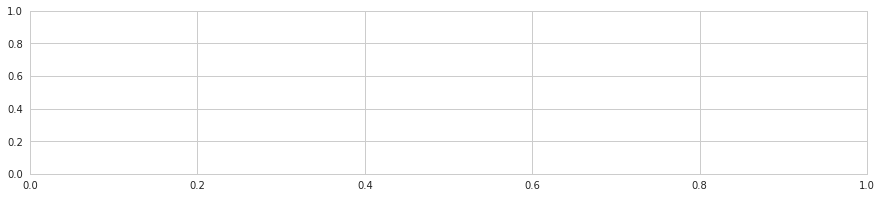

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.utils - ERROR - 
Traceback (most recent call last):
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/distributed/utils.py", line 662, in log_errors
    yield
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/distributed/client.py", line 1290, in _close
    await gen.with_timeout(timedelta(seconds=2), list(coroutines))
concurrent.futures._base.CancelledError
distributed.utils - ERROR - 
Traceback (most recent call last):
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/distributed/utils.py", line 662, in log_errors
  

In [122]:
dfd = dd.from_pandas(df, npartitions=4) 
client.persist(dfd)
import pytz

def plot_count(dfd, title):
    years = range(2010,2019)
    fig, ax = plt.subplots(figsize=(15,3))
    for y in years:
        start = datetime.datetime.strptime('{}0101'.format(y), '%Y%m%d')
        end = datetime.datetime.strptime('{}0131'.format(y), '%Y%m%d')

        start = start.replace(tzinfo=pytz.UTC)
        end = end.replace(tzinfo=pytz.UTC)
            
        #dfy = dfd.loc['{}0101'.format(y):'{}1231'.format(y), :]    
        print(dfd.index)
        dfy = dfd.loc[start:end, :]    
        #s = dfy.loc[:,'Parameter'].groupby(by=[pd.Grouper(freq='D')]).count().compute()
        s = dfy.groupby(by=['Parameter']).count().compute()
        #plt.bar(s.index.to_pydatetime(),s.values)
        progress(dfy)
    
    plt.grid(False)
    plt.title(title)
    plt.gcf().autofmt_xdate()
    
plot_count(dfd[(dfd.loc[:,'Parameter'] == 'WindGust') & (dfd.loc[:,'Low Limit'] == 15)], 'Wind Gust 15 m/s')
plot_count(dfd[(dfd.loc[:,'Parameter'] == 'WindGust') & (dfd.loc[:,'Low Limit'] == 20)], 'Wind Gust 20 m/s')
plot_count(dfd[(dfd.loc[:,'Parameter'] == 'WindGust') & (dfd.loc[:,'Low Limit'] == 25)], 'Wind Gust 25 m/s')
plot_count(dfd[(dfd.loc[:,'Parameter'] == 'Pressure')], 'Pressure 1000 hPa')

In [197]:
print(len(df))
print(len(dft))

44857
20785
